In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from keras import regularizers

import matplotlib.pyplot as plt

### Загрузка и предобработка данных

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_data.csv', sep=';')
data.columns = data.columns.str.lower()
data.rename(columns={'unnamed: 0': 'timestamp'}, inplace=True)

In [3]:
data.head()

,timestamp,t_data_1_1,t_data_1_2,t_data_1_3,t_data_2_1,t_data_2_2,t_data_2_3,t_data_3_1,t_data_3_2,t_data_3_3,t_data_4_1,t_data_4_2,t_data_4_3,t_data_5_1,t_data_5_2,t_data_5_3,h_data,ah_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [4]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103841 entries, 0 to 2103840
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   timestamp   2103841 non-null  object 
 1   t_data_1_1  2103841 non-null  int64  
 2   t_data_1_2  2103841 non-null  int64  
 3   t_data_1_3  2103841 non-null  int64  
 4   t_data_2_1  2103841 non-null  int64  
 5   t_data_2_2  2103841 non-null  int64  
 6   t_data_2_3  2103841 non-null  int64  
 7   t_data_3_1  2103841 non-null  int64  
 8   t_data_3_2  2103841 non-null  int64  
 9   t_data_3_3  2103841 non-null  int64  
 10  t_data_4_1  2103841 non-null  int64  
 11  t_data_4_2  2103841 non-null  int64  
 12  t_data_4_3  2103841 non-null  int64  
 13  t_data_5_1  2103841 non-null  int64  
 14  t_data_5_2  2103841 non-null  int64  
 15  t_data_5_3  2103841 non-null  int64  
 16  h_data      2103841 non-null  float64
 17  ah_data     2103841 non-null  float64
dtypes: float64(2), int64(1

Пропусков нет, изменим тип данных в столбце с датой на datetime:

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
#для сопоставления фич и предикта установим во всех датафреймах дату в качестве индекса:
data = data.set_index(['timestamp'])
data.head()

,t_data_1_1,t_data_1_2,t_data_1_3,t_data_2_1,t_data_2_2,t_data_2_3,t_data_3_1,t_data_3_2,t_data_3_3,t_data_4_1,t_data_4_2,t_data_4_3,t_data_5_1,t_data_5_2,t_data_5_3,h_data,ah_data
timestamp,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [6]:
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_train.csv', sep=';', header=None, index_col=0)

In [7]:
y_train.head()

,1
0,
2015-01-04 00:05:00,392
2015-01-04 01:05:00,384
2015-01-04 02:05:00,393
2015-01-04 03:05:00,399
2015-01-04 04:05:00,400


In [8]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29184 entries, 2015-01-04 00:05:00 to 2018-05-03 23:05:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       29184 non-null  int64
dtypes: int64(1)
memory usage: 456.0+ KB


In [9]:
y_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Y_submit.csv', sep=';', header=None, index_col=0)

In [10]:
y_submit.head()

,1
0,
2018-05-04 00:05:00,420
2018-05-04 01:05:00,420
2018-05-04 02:05:00,420
2018-05-04 03:05:00,420
2018-05-04 04:05:00,420


In [11]:
y_submit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5808 entries, 2018-05-04 00:05:00 to 2018-12-31 23:05:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       5808 non-null   int64
dtypes: int64(1)
memory usage: 90.8+ KB


У датафреймов с таргетами пропусков нет, тип данных корректный.

In [12]:
print("Временные интервалы данных:")
print("Данные:\n", data.index.min(), data.index.max())
print("Тренировочный таргет:\n", y_train.index.min(), y_train.index.max())
print("Предсказываемый таргет:\n", y_submit.index.min(), y_submit.index.max())

Временные интервалы данных:
Данные:
 2015-01-01 00:00:00 2019-01-01 00:00:00
Тренировочный таргет:
 2015-01-04 00:05:00 2018-05-03 23:05:00
Предсказываемый таргет:
 2018-05-04 00:05:00 2018-12-31 23:05:00


Временной интервал данных покрывает временные интервалы для предсказания, однако частота измерений различается - данные поступают каждую минуту, а таргет - каждый час. 

In [13]:
#Просуммируем значения за час
df = data.resample('H').sum().shift(freq='5T')
df.head()

,t_data_1_1,t_data_1_2,t_data_1_3,t_data_2_1,t_data_2_2,t_data_2_3,t_data_3_1,t_data_3_2,t_data_3_3,t_data_4_1,t_data_4_2,t_data_4_3,t_data_5_1,t_data_5_2,t_data_5_3,h_data,ah_data
timestamp,,,,,,,,,,,,,,,,,
2015-01-01 00:05:00,12792,12814,12665,19251,19763,20657,30091,28380,29166,22044,21201,21004,14800,14458,14388,9916.70,553.2
2015-01-01 01:05:00,12581,12281,12753,17372,16235,21292,31718,28530,29452,20720,21288,20615,14261,14346,14256,9884.80,469.2
2015-01-01 02:05:00,13858,11466,12590,17470,18715,20523,30630,29367,29197,21518,20707,20613,14271,13910,14329,9905.15,361.8
2015-01-01 03:05:00,13660,13300,13363,19547,9205,20619,27404,28411,28871,20269,21211,20995,14145,14396,14205,9925.37,501.6
2015-01-01 04:05:00,14146,14389,15004,20816,15367,20746,25462,28857,29024,20160,21290,21278,14406,14508,14338,9903.69,421.2


Помимо суммы добавим столбцы со средними, медианными, максимальными и минимальными значениями

In [14]:
df = df.join(data.resample('H').mean().shift(freq='5T'), rsuffix="mean")
df = df.join(data.resample('H').median().shift(freq='5T'), rsuffix="median")
df = df.join(data.resample('H').max().shift(freq='5T'), rsuffix="max")
df = df.join(data.resample('H').min().shift(freq='5T'), rsuffix="min")
df = df.join(data.resample('H').var().shift(freq='5T'), rsuffix="var")
df = df.join(data.resample('H').std().shift(freq='5T'), rsuffix="std")
df.head()

,t_data_1_1,t_data_1_2,t_data_1_3,t_data_2_1,t_data_2_2,t_data_2_3,t_data_3_1,t_data_3_2,t_data_3_3,t_data_4_1,t_data_4_2,t_data_4_3,t_data_5_1,t_data_5_2,t_data_5_3,h_data,ah_data,t_data_1_1mean,t_data_1_2mean,t_data_1_3mean,t_data_2_1mean,t_data_2_2mean,t_data_2_3mean,t_data_3_1mean,t_data_3_2mean,t_data_3_3mean,t_data_4_1mean,t_data_4_2mean,t_data_4_3mean,t_data_5_1mean,t_data_5_2mean,t_data_5_3mean,h_datamean,ah_datamean,t_data_1_1median,t_data_1_2median,t_data_1_3median,t_data_2_1median,t_data_2_2median,t_data_2_3median,...,t_data_4_3min,t_data_5_1min,t_data_5_2min,t_data_5_3min,h_datamin,ah_datamin,t_data_1_1var,t_data_1_2var,t_data_1_3var,t_data_2_1var,t_data_2_2var,t_data_2_3var,t_data_3_1var,t_data_3_2var,t_data_3_3var,t_data_4_1var,t_data_4_2var,t_data_4_3var,t_data_5_1var,t_data_5_2var,t_data_5_3var,h_datavar,ah_datavar,t_data_1_1std,t_data_1_2std,t_data_1_3std,t_data_2_1std,t_data_2_2std,t_data_2_3std,t_data_3_1std,t_data_3_2std,t_data_3_3std,t_data_4_1std,t_data_4_2std,t_data_4_3std,t_data_5_1std,t_data_5_2std,t_data_5_3std,h_datastd,ah_datastd
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:05:00,12792,12814,12665,19251,19763,20657,30091,28380,29166,22044,21201,21004,14800,14458,14388,9916.70,553.2,213.200000,213.566667,211.083333,320.850000,329.383333,344.283333,501.516667,473.000000,486.100000,367.400000,353.350000,350.066667,246.666667,240.966667,239.800000,165.278333,9.22,214.0,214.0,211.0,319.5,330.5,344.0,...,346,241,240,238,161.27,9.22,0.976271,1.639548,0.077684,196.807627,233.189548,1.087853,210.457345,0.000000,8.091525,284.583051,6.265254,8.368362,4.836158,0.032768,2.230508,4.178658,0.0,0.988064,1.280448,0.278718,14.028814,15.270545,1.043002,14.507148,0.000000,2.844561,16.869590,2.503049,2.892812,2.199127,0.181020,1.493489,2.044177,0.0
2015-01-01 01:05:00,12581,12281,12753,17372,16235,21292,31718,28530,29452,20720,21288,20615,14261,14346,14256,9884.80,469.2,209.683333,204.683333,212.550000,289.533333,270.583333,354.866667,528.633333,475.500000,490.866667,345.333333,354.800000,343.583333,237.683333,239.100000,237.600000,164.746667,7.82,209.0,205.5,213.0,288.0,264.5,354.5,...,342,235,237,237,160.30,7.82,2.186158,33.914972,0.251695,19.642938,216.687853,35.541243,4.846328,4.627119,0.117514,227.717514,3.281356,1.026836,5.575989,0.362712,0.244068,4.971840,0.0,1.478566,5.823656,0.501692,4.432035,14.720321,5.961648,2.201438,2.151074,0.342803,15.090312,1.811451,1.013329,2.361353,0.602256,0.494032,2.229762,0.0
2015-01-01 02:05:00,13858,11466,12590,17470,18715,20523,30630,29367,29197,21518,20707,20613,14271,13910,14329,9905.15,361.8,230.966667,191.100000,209.833333,291.166667,311.916667,342.050000,510.500000,489.450000,486.616667,358.633333,345.116667,343.550000,237.850000,231.833333,238.816667,165.085833,6.03,229.5,189.0,210.0,290.0,307.5,338.5,...,342,235,229,238,159.44,6.03,156.100565,30.972881,0.819209,29.124294,1187.942090,155.370339,142.796610,14.624576,5.969209,36.676836,6.138701,1.031356,1.994068,4.649718,0.152260,5.174777,0.0,12.494021,5.565329,0.905102,5.396693,34.466536,12.464764,11.949754,3.824209,2.443196,6.056140,2.477640,1.015557,1.412115,2.156320,0.390205,2.274814,0.0
2015-01-01 03:05:00,13660,13300,13363,19547,9205,20619,27404,28411,28871,20269,21211,20995,14145,14396,14205,9925.37,501.6,227.666667,221.666667,222.716667,325.783333,153.416667,343.650000,456.733333,473.516667,481.183333,337.816667,353.516667,349.916667,235.750000,239.933333,236.750000,165.422833,8.36,226.5,222.0,221.5,324.5,135.0,346.0,...,346,235,235,236,161.94,8.36,93.683616,22.293785,64.443785,223.087853,2034.213277,32.604237,244.978531,55.643785,0.152260,18.830226,31.745480,7.162429,1.241525,4.198870,0.597458,2.572065,0.0,9.679030,4.721630,8.027689,14.936126,45.102254,5.710012,15.651790,7.459476,0.390205,4.339381,5.634313,2.676272,1.114238,2.049114,0.772954,1.603766,0.0
2015-01-01 04:05:00,14146,14389,15004,20816,15367,20746,25462,28857,29024,20160,21290,21278,14406,14508,1

Сопоставим временные интервалы данных и тренировочных таргетов

In [15]:
X = df.loc[df.index.isin(y_train.index)]
X.shape, y_train.shape

((29184, 119), (29184, 1))

In [16]:
features_train, features_valid, target_train, target_valid = train_test_split(X, y_train.values, 
                                                          test_size=0.3, random_state=777)

### Использование классических моделей ML

In [17]:
params = {'colsample_bytree': 0.7,
          'learning_rate': 0.075,
          'max_depth': 5,
          'min_child_weight': 3,
          'n_estimators': 330,
          'nthread': 4,
          'objective': 'reg:linear',
          'silent': 1,
          'subsample': 0.7}

In [18]:
rfr = RandomForestRegressor(n_estimators=130, max_depth=70, random_state=777)
lr = LinearRegression()
xgbc = xgb.XGBRegressor(**params)
models = (rfr, lr, xgbc)

In [19]:
mae_total = []
for mod in models:
    mod.fit(features_train, target_train)
    #predicted_valid = mod.predict(features_valid)
    print("Модель:", mod)
    pred = mod.predict(features_valid)
    mae = mean_absolute_error(target_valid, pred)
    print("MAE:", mae, "\n")
    mae_total.append(mae)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Модель: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=130, n_jobs=None, oob_score=False,
                      random_state=777, verbose=0, warm_start=False)
MAE: 11.205734968549038 

Модель: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE: 15.260072107446105 

Модель: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.075, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=None, n_estimators=330,
             n_jobs=1, nthread=4, objective='reg:linear', random

In [20]:
# Разобьем валид сет на тест и валид для последующих проверок:
# feat_val_train, feat_val_val, target_val_train, target_val_val = train_test_split(features_valid, target_valid, 
#                                                           test_size=0.5, random_state=80022021)
# xgbc = xgb.XGBRegressor(colsample_bytree= 0.7,
#         learning_rate= 0.05,
#         max_depth= 5,
#         min_child_weigh= 3,
#         n_estimators= 2500,
#         nthread= 4,
#         objective= 'reg:linear',
#         silent= 1,
#         subsample= 0.7)
# xgbc.fit(features_train, target_train)
# pred = xgbc.predict(feat_val_train)
# mae = mean_absolute_error(target_val_train, pred)
# print("MAE:", mae, "\n")


In [21]:
# #проверка на недо- и пере-обучение
# scores = -cross_val_score(xgbc, feat_val_val, target_val_val, cv=5, scoring='neg_mean_absolute_error')
# print("Mean cross-validation score: %.2f" % scores.mean())

In [22]:
# from sklearn.model_selection import cross_val_score
# #Проверить CV
# scores = cross_val_score(rfr, features_train, target_train, cv=5)
# print("Mean cross-validation score: %.2f" % scores.mean())

# scores = cross_val_score(xgbc, features_train, target_train, cv=5)
# print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(xgbc, features_train, target_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [23]:
#Поиск лучших параметров
# from sklearn.model_selection import GridSearchCV

# xgb1 = xgb.XGBRegressor()
# parameters = {'nthread':[4],
#               'objective':['reg:linear'],
#               'learning_rate': [0.01, 0.05, 0.1, 0.5],
#               'max_depth': [4, 5, 6],
#               'min_child_weight': [3],
#               'silent': [1],
#               'subsample': [0.5, 0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [50, 100, 500, 700]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 3,
#                         n_jobs = 5,
#                         verbose=True)
# xgb_grid.fit(X,
#          y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

In [24]:
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
# from sklearn.model_selection import cross_val_score

In [25]:
# Быстрый поиск
# def hyperopt_xgb_score(params):
#     clf = xgb.XGBRegressor(**params)
#     # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
#     # для ускорения можно использовать train_test_split один раз
#     current_score = cross_val_score(clf, X, y_train, scoring='neg_mean_absolute_error', cv=3).mean()
#     print(current_score, params)
#     return -current_score
 
 
# simple_space_xgb = {
#             'n_estimators': hp.choice('n_estimators', range(100, 1200)),
#             'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
#             'max_depth':  hp.choice('max_depth', np.arange(5, 6, dtype=int)),
#             'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
#             'subsample': hp.quniform('subsample', 0.7),
#             'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
#             'colsample_bytree': hp.quniform('colsample_bytree', 0.7),
#             'eval_metric': 'mae',
            
#             # Increase this number if you have more cores. Otherwise, remove it and it will default
#             # to the maxium number.
#             'nthread': 4,
#             'booster': 'gbtree',
#             'tree_method': 'exact',
#             'silent': 1,
#             'scale_pos_weight': 12
#         }
 
# best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=15)
# print('best:')
# print(best)

### Модель машинного обучения на основе Keras

In [26]:
model = keras.Sequential([
                       keras.layers.Dense(256, kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(features_train.shape[-1],)), 
                       keras.layers.BatchNormalization(),
                       keras.layers.Dropout(0.5), 
                       keras.layers.Dense(128, kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(0.001),), 
                       keras.layers.Dropout(0.5), 
                       keras.layers.Dense(64, kernel_initializer='normal', activation='relu',kernel_regularizer=keras.regularizers.l2(0.001),), 
                       keras.layers.Dropout(0.5),
                       keras.layers.Dense(1, kernel_initializer='normal'),
                       ])

metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error']
# callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="mean_absolute_error", metrics=metrics
)
model.summary()
model_history = model.fit(features_train,
                            target_train,
                            epochs=150,
                            batch_size=16,
                            validation_data=(features_valid, target_valid),
                            verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               30720     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

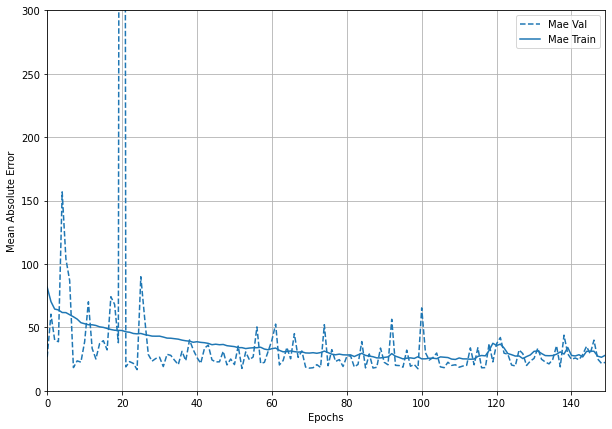

In [27]:
def plot_history(histories, key='mean_absolute_error'):
  plt.figure(figsize=(10,7))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], 
             color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylim(0, 300)
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.grid()

  plt.xlim([0,max(history.epoch)])
  
plot_history([('MAE', model_history)])

In [28]:
mae_total.append(mean_absolute_error(model.predict(features_valid), target_valid))
mean_absolute_error(model.predict(features_valid), target_valid)

22.377406838714613

Возможно добавление скрытых слоев и или изменение других параметров улучшит характеристики модели на основе нейронной сети, однако XGBRegression показал себя заметно лучше, поэтому сконцентрируемся на нем.

### Общий анализ моделей

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


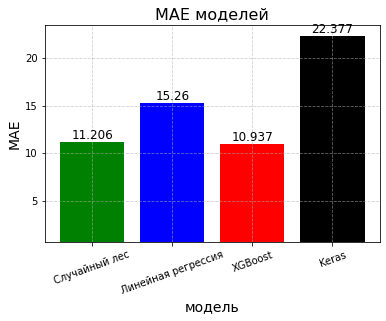

In [29]:
names = ['Случайный лес', 'Линейная регрессия', 'XGBoost', "Keras"]
plt.bar(names, mae_total, color='gbrk')
plt.title('MAE моделей', fontsize=16)
plt.xlabel("модель", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.ylim(.6)
plt.grid(linestyle='--', alpha=0.6)
ra_total_round = [round(i,3) for i in mae_total]
for i, val in enumerate(ra_total_round):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':100, 'size':12})
plt.xticks(rotation=20)
plt.show()

In [30]:
fi_new = pd.Series(xgbc.feature_importances_, index=X.columns)
fi_new = fi_new / fi_new.sum()

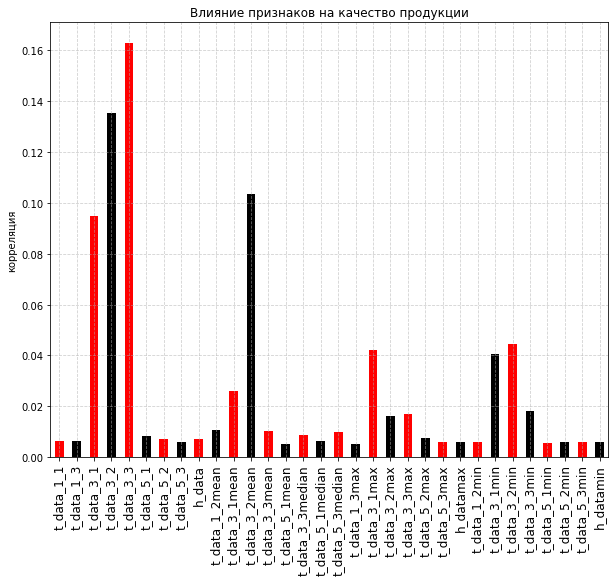

In [31]:
plt.figure(figsize=(10,8))
fi_new[fi_new > 0.005].plot(kind='bar', grid=True, color=['r','k'])
plt.grid(linestyle='--', alpha=0.6)
plt.xticks(rotation=90, fontsize = 12)
plt.title("Влияние признаков на качество продукции")
plt.ylabel("корреляция")
plt.show()

Модель на основе XGBoost показала лучший результат (MAE~10.9), поэтому итоговое предсказание будем выполнять с её помощью.

### Итоговое предсказание с использованием лучшей модели

In [32]:
X_submit = df.loc[df.index.isin(y_submit.index)]
X_submit.shape, y_submit.shape

((5808, 119), (5808, 1))

In [33]:
y_pred = pd.DataFrame(xgbc.predict(X_submit), index=y_submit.index)
y_pred.head()

,0
0,
2018-05-04 00:05:00,444.122131
2018-05-04 01:05:00,434.742157
2018-05-04 02:05:00,408.761353
2018-05-04 03:05:00,405.814331
2018-05-04 04:05:00,409.778564


In [34]:
y_pred.to_csv('y_pred.csv', sep=";", header=None)

### Заключение

В ходе выполнения данного задания была сформирована обучающая выборка посредством группировки данных с помощью агрегирующих функций: sum, mean, min, max, var и т.д. Обучены несколько моделей ML среди которых выбрана лучшая по MAE. Ей оказалась  модель на основе XGBoost с метрикой MAE~10.9. С помощью данной модели было спрогнозировано качество продукции, производимое на обжиговой машине.



В дальнейшем, для улучшения модели, предлагается сгенерировать больше признаков для обучения (например, 10%, 25%, 75%, 90%-квантили, разностные характеристики и т.д.), подобрать оптимальные параметры, избавиться от переобучения.